# Auto-graded section

The block below imports the necessary packages for this assignment.

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import sklearn

## 0. The Dow Dataset (2.5 pts)

From now on, you will work with a new dataset, which is the Dow dataset. Read in the `impurity_dataset-training.xlsx` as a `pandas.DataFrame` with a variable name `df`. (2.5 pts)

Note: If you run this on a computer without Microsoft Excel you may get an error. However, it should work reliably in the Vocareum environment.

In [2]:
#####################################################
df = pd.read_excel("impurity_dataset-training.xlsx")
#####################################################

In [3]:
assert type(df) == pd.core.frame.DataFrame
assert df.shape == (10703, 46)
assert np.isclose(np.linalg.norm(df[df.columns[1:]].loc[1]), 3381.2181210675867)

The cell below will clean the `df` to remove invalid cells and missing values. This cell create two variables `X` and `y` that will be the input feature matrix and corresponding impurity concentrations, respectively. You don't need to understand how this works yet, but we will cover it in future lessons.

In [4]:
def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True

all_data = df[df.columns[1:]].values #drop the first column (date)
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
real_rows = numeric_map.all(axis=1).copy().values #True if all values in a row are real numbers
X = np.array(all_data[real_rows,:-5], dtype='float') #drop the last 5 cols that are not inputs
y = np.array(all_data[real_rows,-3], dtype='float')
y = y.reshape(-1,1)

## 1. Feature Scaling (37.5 pts)

In this problem, you will see how feature scaling will affect the model performance. First, import `StandardScaler` and `MinMaxScaler` from `scikit-learn`. Declare a `StandardScaler` object `ss` and a `MinMaxScaler` object `mms`. Do not change any default parameter settings for both scaler objects. (7.5 pts)

In [5]:
#################################################
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ss = StandardScaler()
mms = MinMaxScaler()
#################################################

In [6]:
assert type(ss) == sklearn.preprocessing._data.StandardScaler
assert type(mms) == sklearn.preprocessing._data.MinMaxScaler

assert ss.with_mean and ss.with_std, "default setting for StandardScaler changed"
assert mms.feature_range == (0, 1), "default setting for MinMaxScaler changed"

Train a LASSO model with the Dow dataset and find the best scaling method (among no scaling, standard scaling, and min-max scaling). More detailed instructions are below.

- Do a train/test split on `X` and `y` by `train_test_split` with `test_size=0.3` and `random_state=42`. The training set and test set should be named as `*_train` and `*_test` where `*` denotes either `X` or `y`, respectively. (10 pts)
- Declare a LASSO model with `alpha=1e-4` and `tol=0.15`. Assign the LASSO model to the variable `lasso`. (5 points)
- For each scaling method, train the LASSO model on the training set and provide the $\mathrm{r^2}$ for the test set.
- Report the best $\mathrm{r^2}$ as `r2_opt`. (10 pts)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

##########################################################################
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lasso = Lasso(alpha =1e-4, tol =0.15)           # defn
lasso.fit(X_train, y_train)                     # training
y_noscaling = lasso.predict(X_test)             # test data prediction
r2_noscaling = r2_score(y_test, y_noscaling)    # accuracy metrics

ss.fit(X_train)
X_train_SS = ss.transform(X_train)              # scaling train data
X_test_SS = ss.transform(X_test)                # scaling test data
lasso.fit(X_train_SS, y_train)                  # training model
y_ss = lasso.predict(X_test_SS)                 # testing model
r2_ss = r2_score(y_test, y_ss)

mms.fit(X_train)
X_train_MMS = mms.transform(X_train)            # scaling train data
X_test_MMS = mms.transform(X_test)              # scaling test data
lasso.fit(X_train_MMS, y_train)                 # training model
y_mms = lasso.predict(X_test_MMS)                # testing model
r2_mms = r2_score(y_test, y_mms)

r2_opt = np.max([r2_noscaling, r2_ss, r2_mms])
#########################################################################

In [8]:
assert X_train.shape == (7207, 40), "test_size not correct"

In [9]:
assert np.isclose(np.linalg.norm(X_test), 229401.15359462335), "random_state not correct"

In [10]:
assert type(lasso) == sklearn.linear_model._coordinate_descent.Lasso, "LASSO model not stored to correct variable"
assert lasso.alpha == 1e-4, "Alpha parameter of LASSO is not correct"
assert lasso.tol == 0.15, "Tolerance not correct"

In [11]:
assert np.isclose(r2_opt, 0.6805049793263493), "r2 not correct"

Report the resulting parameter vector after all features with a coefficient of zero have been dropped in the case of **min-max scaling**. The name of the reduced parameter vector should `dropped_coefs`. (5 pts)

In [12]:
#####################################################################
coefs = lasso.coef_
dropped_coefs = coefs[np.isclose(lasso.coef_,0) == False]
print('Number of non-zero coeffs: ', len(dropped_coefs))
#####################################################################

Number of non-zero coeffs:  35


In [13]:
assert np.isclose(np.linalg.norm(dropped_coefs) * len(dropped_coefs), 495.69726745190184), "parameter vector" 

## 2. Principal Component Analysis (10 pts)

Principal component analysis is closely related to the eigenvalue decomposition of the correlation matrix, as described in the lectures. This problem ensures that you know how to obtain the principal components in this way.

First, create a correlation matrix `corr` from `X`. (5 pts)

In [14]:
########################################
corr = np.corrcoef(X.T)
########################################

In [15]:
assert np.isclose(np.linalg.norm(corr), 24.09288033850843)

Next, get the eigenvectors and corresponding eigenvalues for the correlation matrix. Report the third highest eigenvalue as `eigvec_3` and the eigenvector corresponding to the sixth highest eigenvalue as `eigvec_6`. (5 pts)

Hint: Remember that eigenvectors are stored as columns by default, and that eigenvalues are not guaranteed to be sorted.

In [16]:
from scipy.linalg import eig

#######################################################################################
eigvals, eigvecs = eig(corr)

indices = np.argsort(eigvals)  ### this thing can sort the indices and return them *o*
eigvec_3 = eigvals[indices[-3]] 
eigvec_6 = eigvecs[:, indices[-6]]
#######################################################################################

In [17]:
assert np.isclose(np.real(eigvec_3), 2.33189496669), "Eigenvalue is not correct"
assert np.isclose(eigvec_6[0], 0.13732149628), "Eigenvector is not correct"
assert np.isclose(np.real(eigvec_3) * np.linalg.norm(eigvec_6[:10]), 0.8256564069966813), "Incorrect eigenvalue or eigenvector selected"

# Peer-graded section

## 1. Visualization

Read in `impurity_dataset-training.xlsx` and clean the data using the code provided in the previous section and lecture notes. The result should be a matrix, `X` with all input data (all columns except for the last 5) and a vector, `y` with impurity values (third to last column). All values should be floating point numbers. These variables may still be correctly defined from section "0" above, in which case no additional code is necessary here.

In [18]:
df = pd.read_excel("impurity_dataset-training.xlsx")

def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True

all_data = df[df.columns[1:]].values #drop the first column (date)
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
real_rows = numeric_map.all(axis=1).copy().values #True if all values in a row are real numbers
X = np.array(all_data[real_rows,:-5], dtype='float') #drop the last 5 cols that are not inputs
y = np.array(all_data[real_rows,-3], dtype='float')
y = y.reshape(-1,1)

When working with a high-dimensional data, visualizing the distribution of each feature helps understand the range and distribution of each feature. Plot the distributions of all 40 features as histograms. The code below sets up an 8x5 array of axes which you can use if you wish.

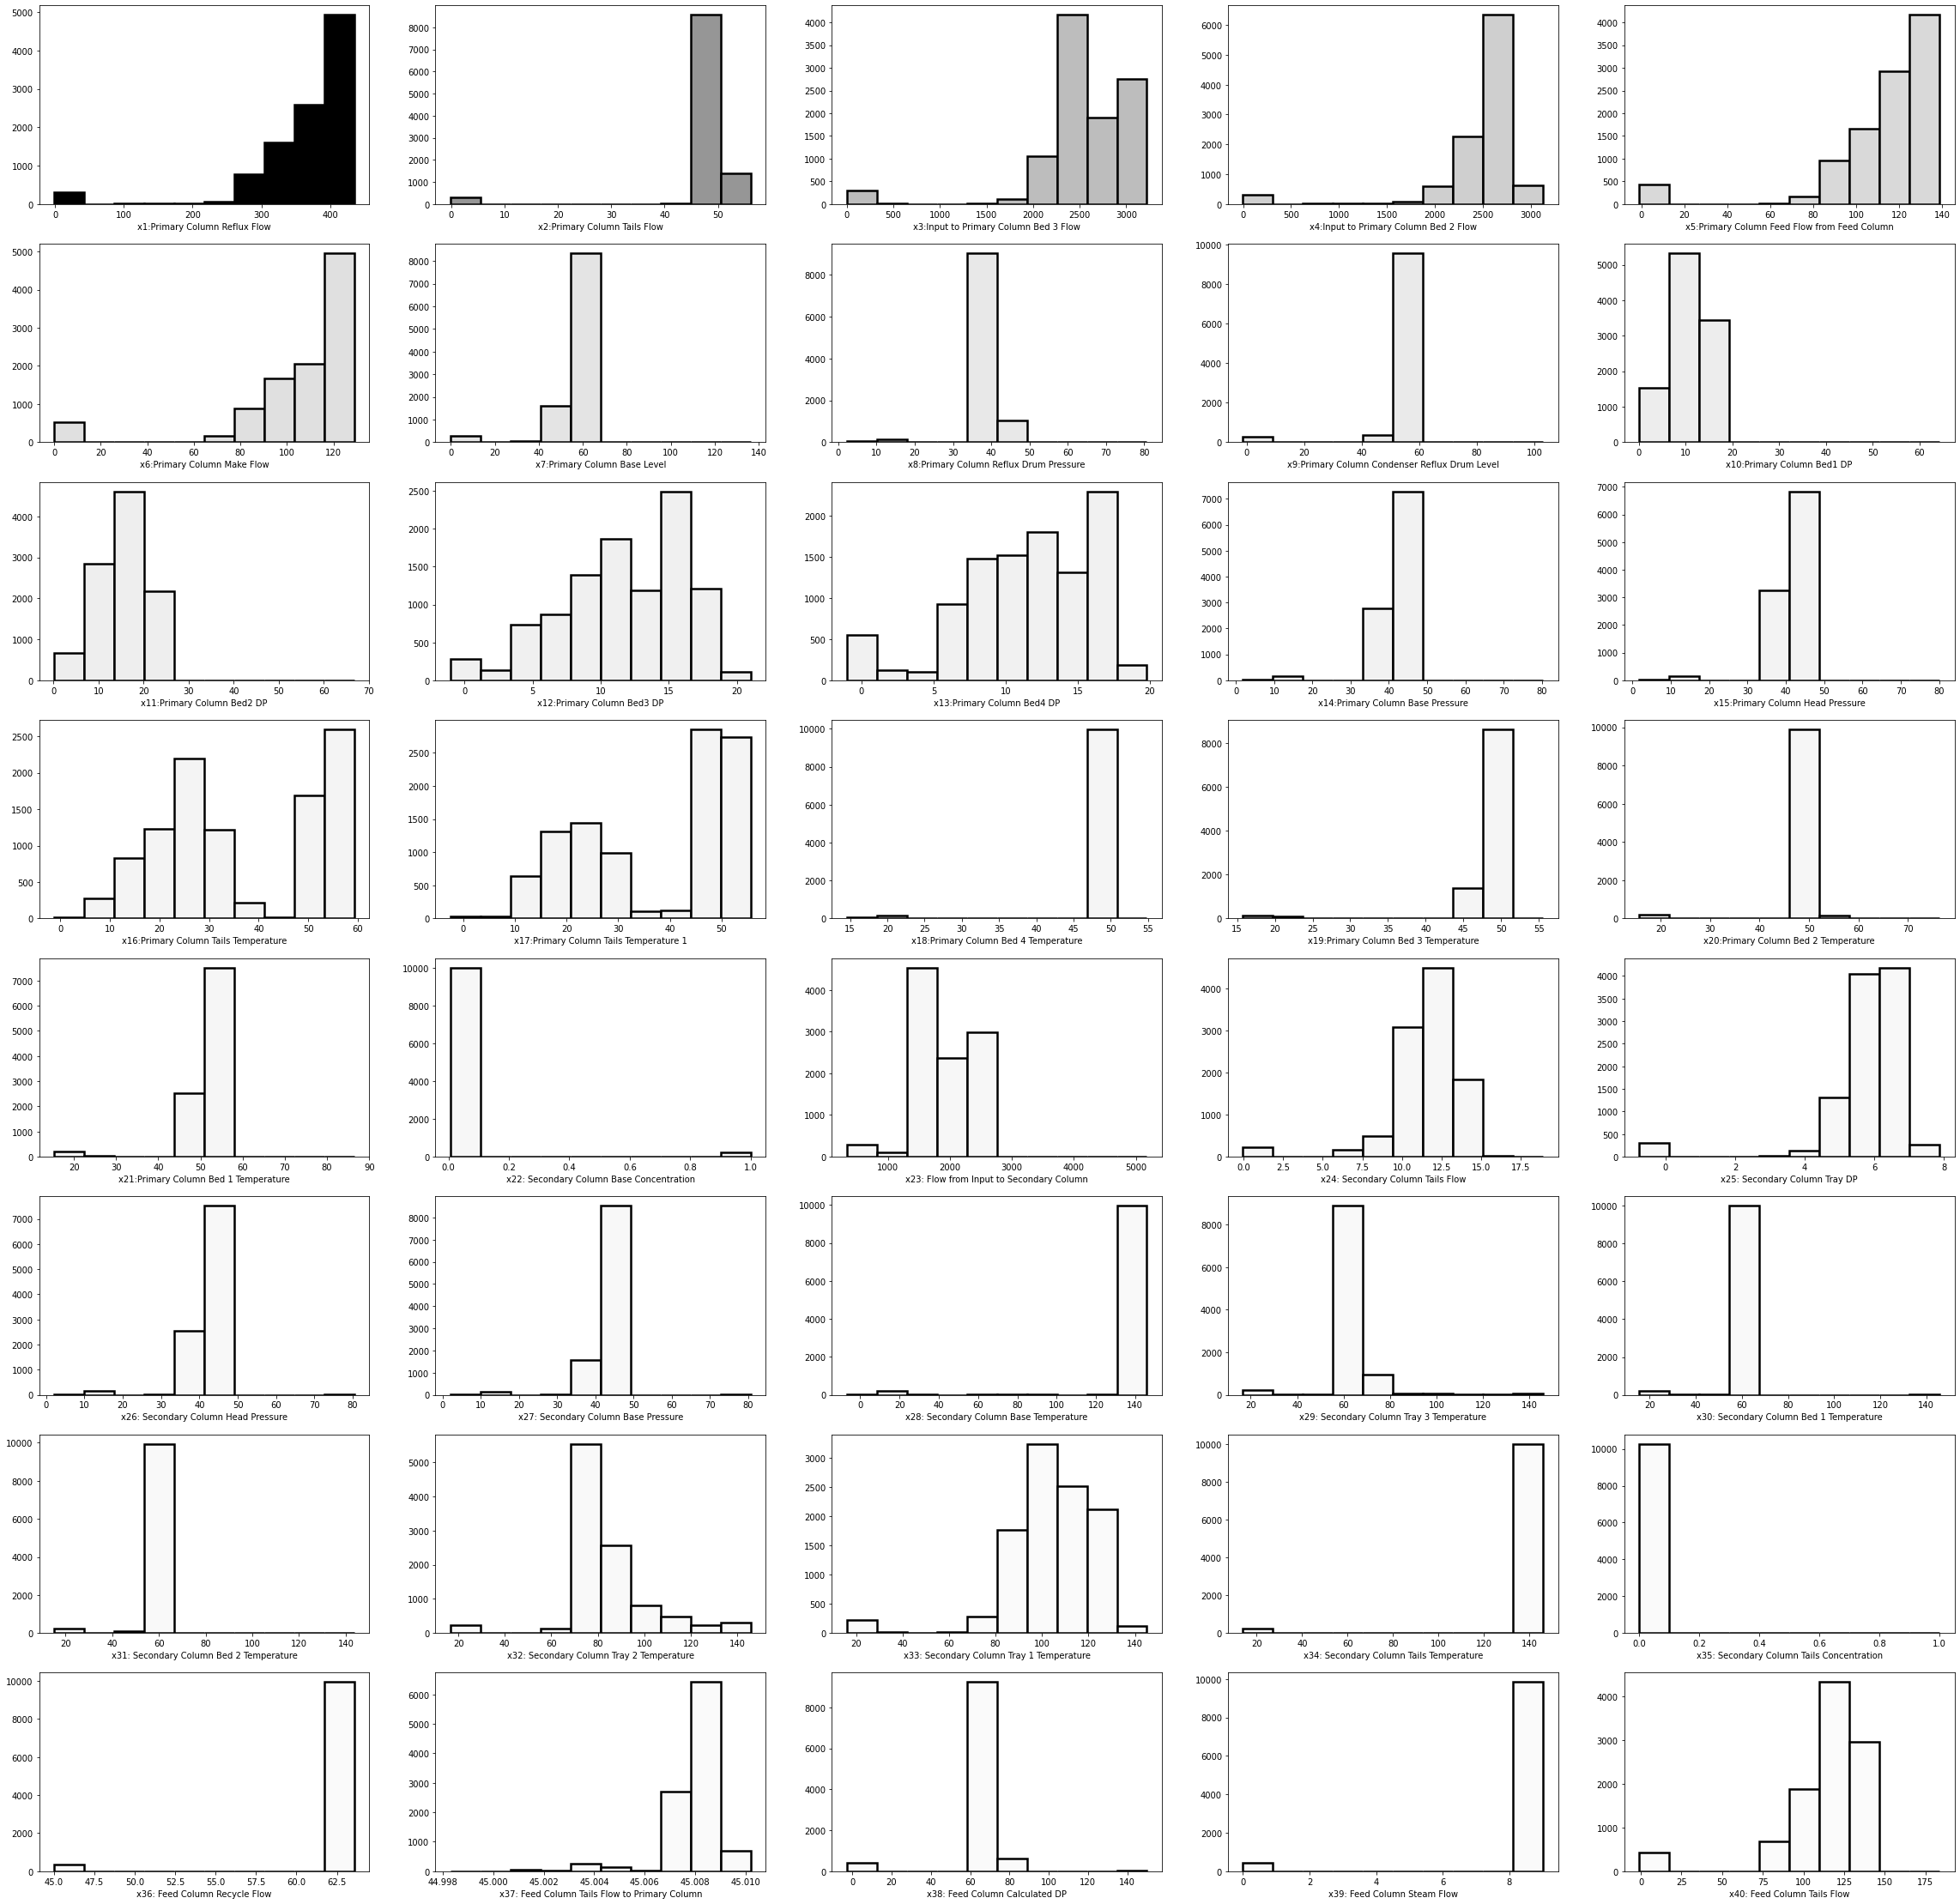

In [19]:
xname = [str(x) for x in df.columns[1:41]]

fig, axes = plt.subplots(8, 5, figsize = (40,40))
ax = axes.ravel()
for i in range(X.shape[-1]):
    ax[i].hist(X[:,i], color = (i/(i+0.7), i/(i+0.7), i/(i+0.7)), edgecolor='k', linewidth=2.5)
    ax[i].set_xlabel(xname[i])

You want to identify outliers for each feature. However, it can be difficult to detect outliers in the original scale. Re-plot the feature histograms with standard-scaled `X` matrix.

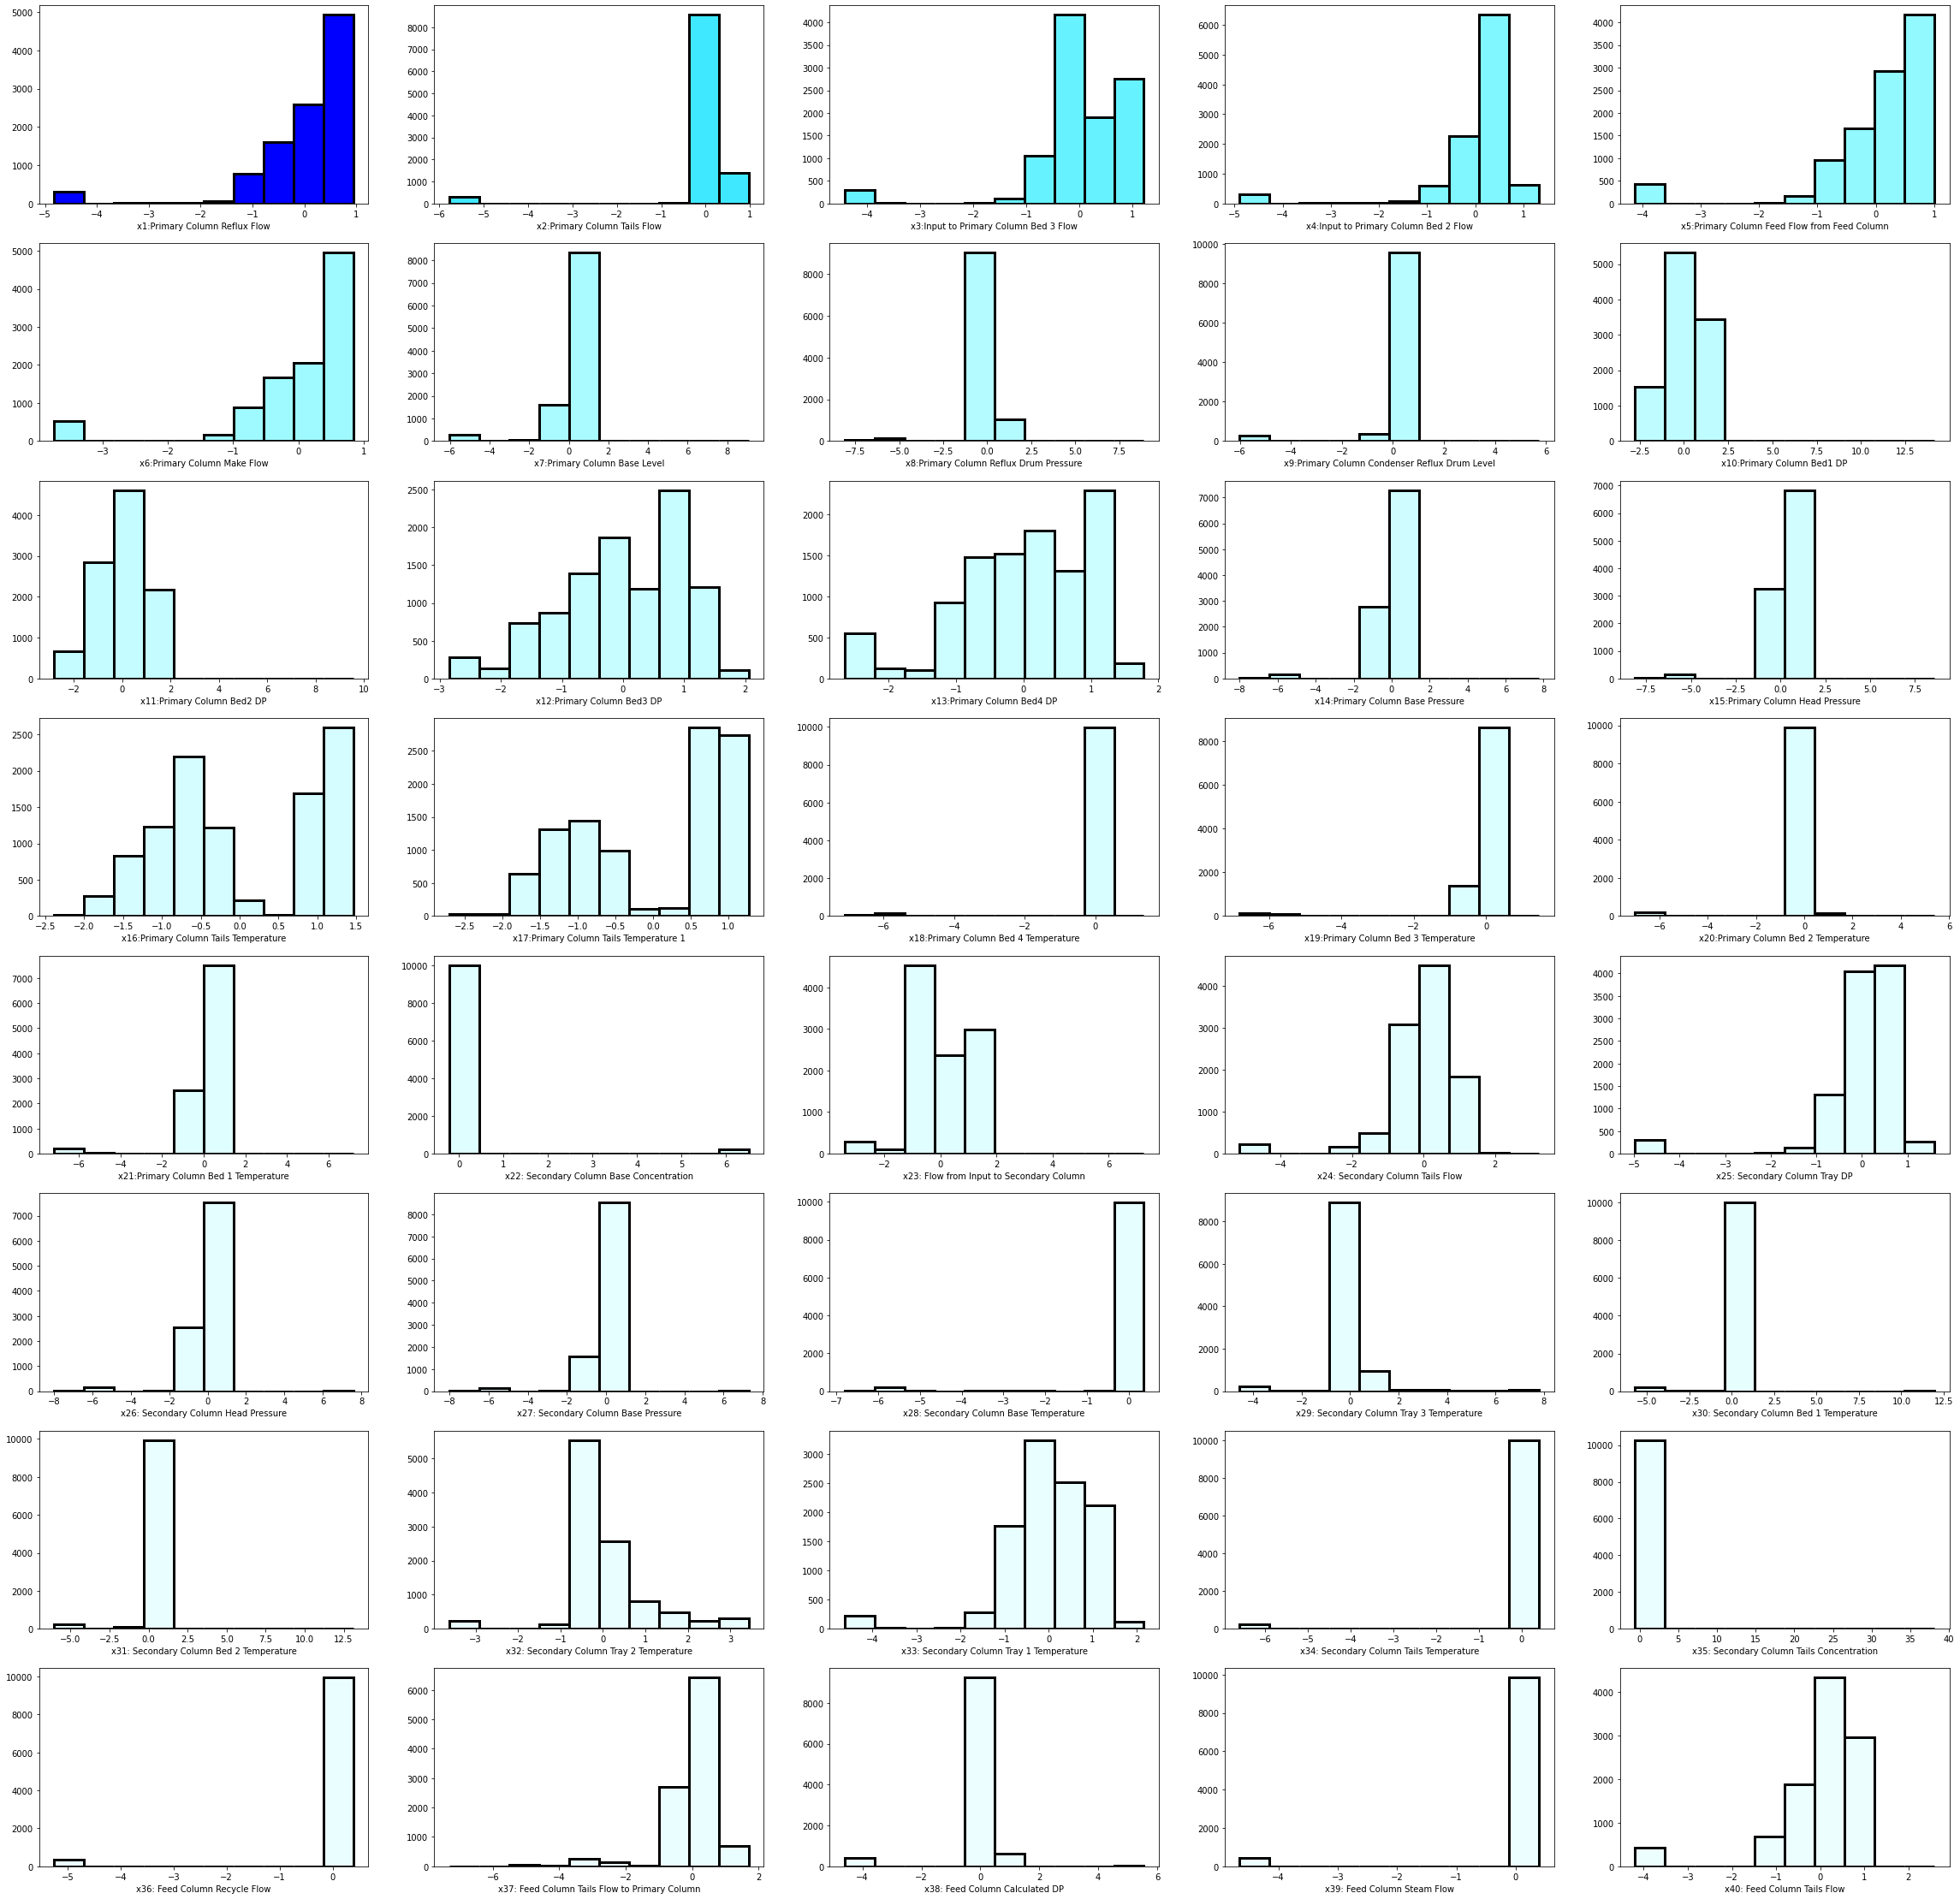

In [20]:
X_scaled = ss.fit(X).transform(X)

fig, axes = plt.subplots(8, 5, figsize = (40,40))
ax = axes.ravel()
for i in range(X_scaled.shape[-1]):
    ax[i].hist(X_scaled[:,i], color = (i/(i+3), i/(i+0.1), 1), edgecolor='k', linewidth=3)
    ax[i].set_xlabel(xname[i])

List the name of features that have outliers based on the definition of outliers being data points that are more than 3$\sigma$ away from the mean. Briefly describe how you came to this conclusion based on the plots above (or another analysis).

**Answer:** Note that in the above dataset (X-scaled) the STD=1 and mean =0, so all the data that have datapoints outside [-3,3] are considered as outliers. From the code below, we can see that almost the features have outliers except 4 features which are mentioned in the output of the code.

In [21]:
range1=[-3,3]
total =0
names = []
N = X_scaled.shape[-1]
for i in range(X_scaled.shape[-1]):
    outliers = [k for k in X_scaled[:,i] if k > 3 or k < -3]
    if len(outliers) == 0:
        total+=1
        names.append(i)

print('There are '+str(total)+' features without outliers:')   

for i in names:
    print(xname[i])

There are 4 features without outliers:
x12:Primary Column Bed3 DP
x13:Primary Column Bed4 DP
x16:Primary Column Tails Temperature
x17:Primary Column Tails Temperature 1


## 2. Principal Component Analysis

As we've learned from the lectures, PCA decomposes a dataset into directions based on maximizing the variance along each principal component vector. In this problem, you will see the relationship between variance and linear correlation with the target values.

Create a scatter plot of the data projected onto the first two principal component vectors. This can be done in two ways- linear algebra or the built-in scikit-learn PCA implementation. You may use either of these methods to achieve this. The number of points on the scatter plot should be equal to the number of rows in the matrix `X`.

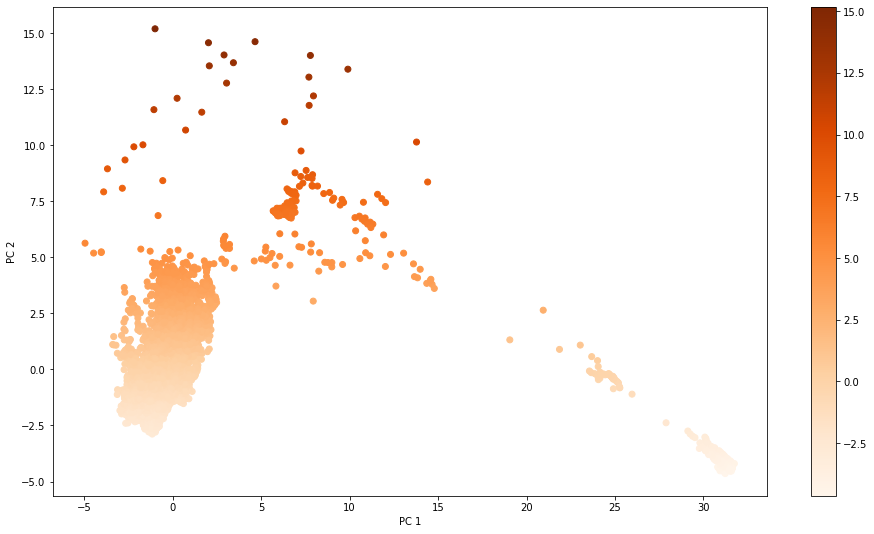

In [22]:
# Using eig function

X_scaled = ss.fit(X).transform(X)
corr = np.corrcoef(X_scaled.T)
eigvals, eigvec = eig(corr)
PC_projection = np.dot(X_scaled, eigvecs)

fig, axes = plt.subplots(figsize=(16, 9))
 
F = plt.scatter(PC_projection[:,0], PC_projection[:,1], c= PC_projection[:,1] ,s=None, marker='o', cmap='Oranges') 
plt.colorbar()
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()


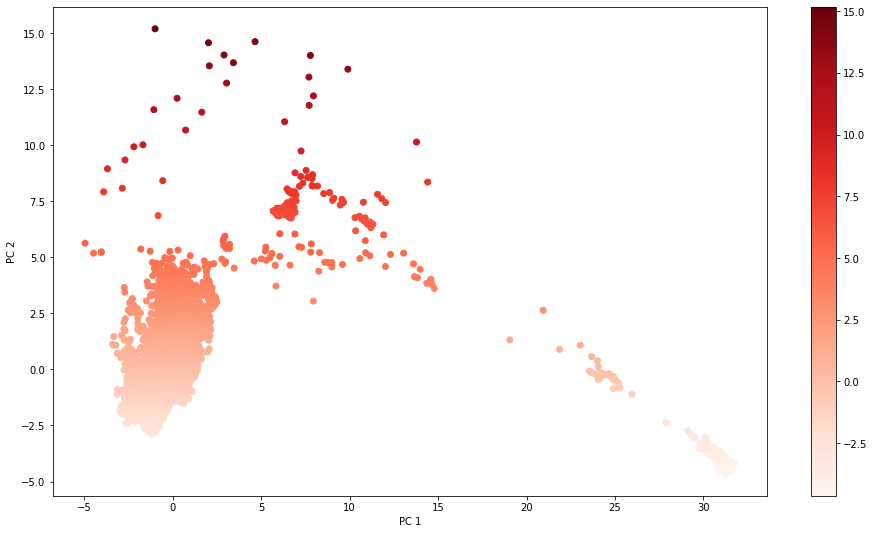

In [23]:
# Using built-in PCA function
from sklearn.decomposition import PCA
N= X_scaled.shape[1]
pca = PCA(N)

PC_projection = pca.fit(X_scaled).transform(X_scaled) ### directly gives you projection

fig, axes = plt.subplots(figsize=(16, 9))
 
F = plt.scatter(PC_projection[:,0], PC_projection[:,1], c= PC_projection[:,1] ,s=None, marker='o', cmap='Reds') 
plt.colorbar()
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

Create a scree plot where the x-axis is the number of the principal component and the y-axis the explained variance of each component (not cumulative). 

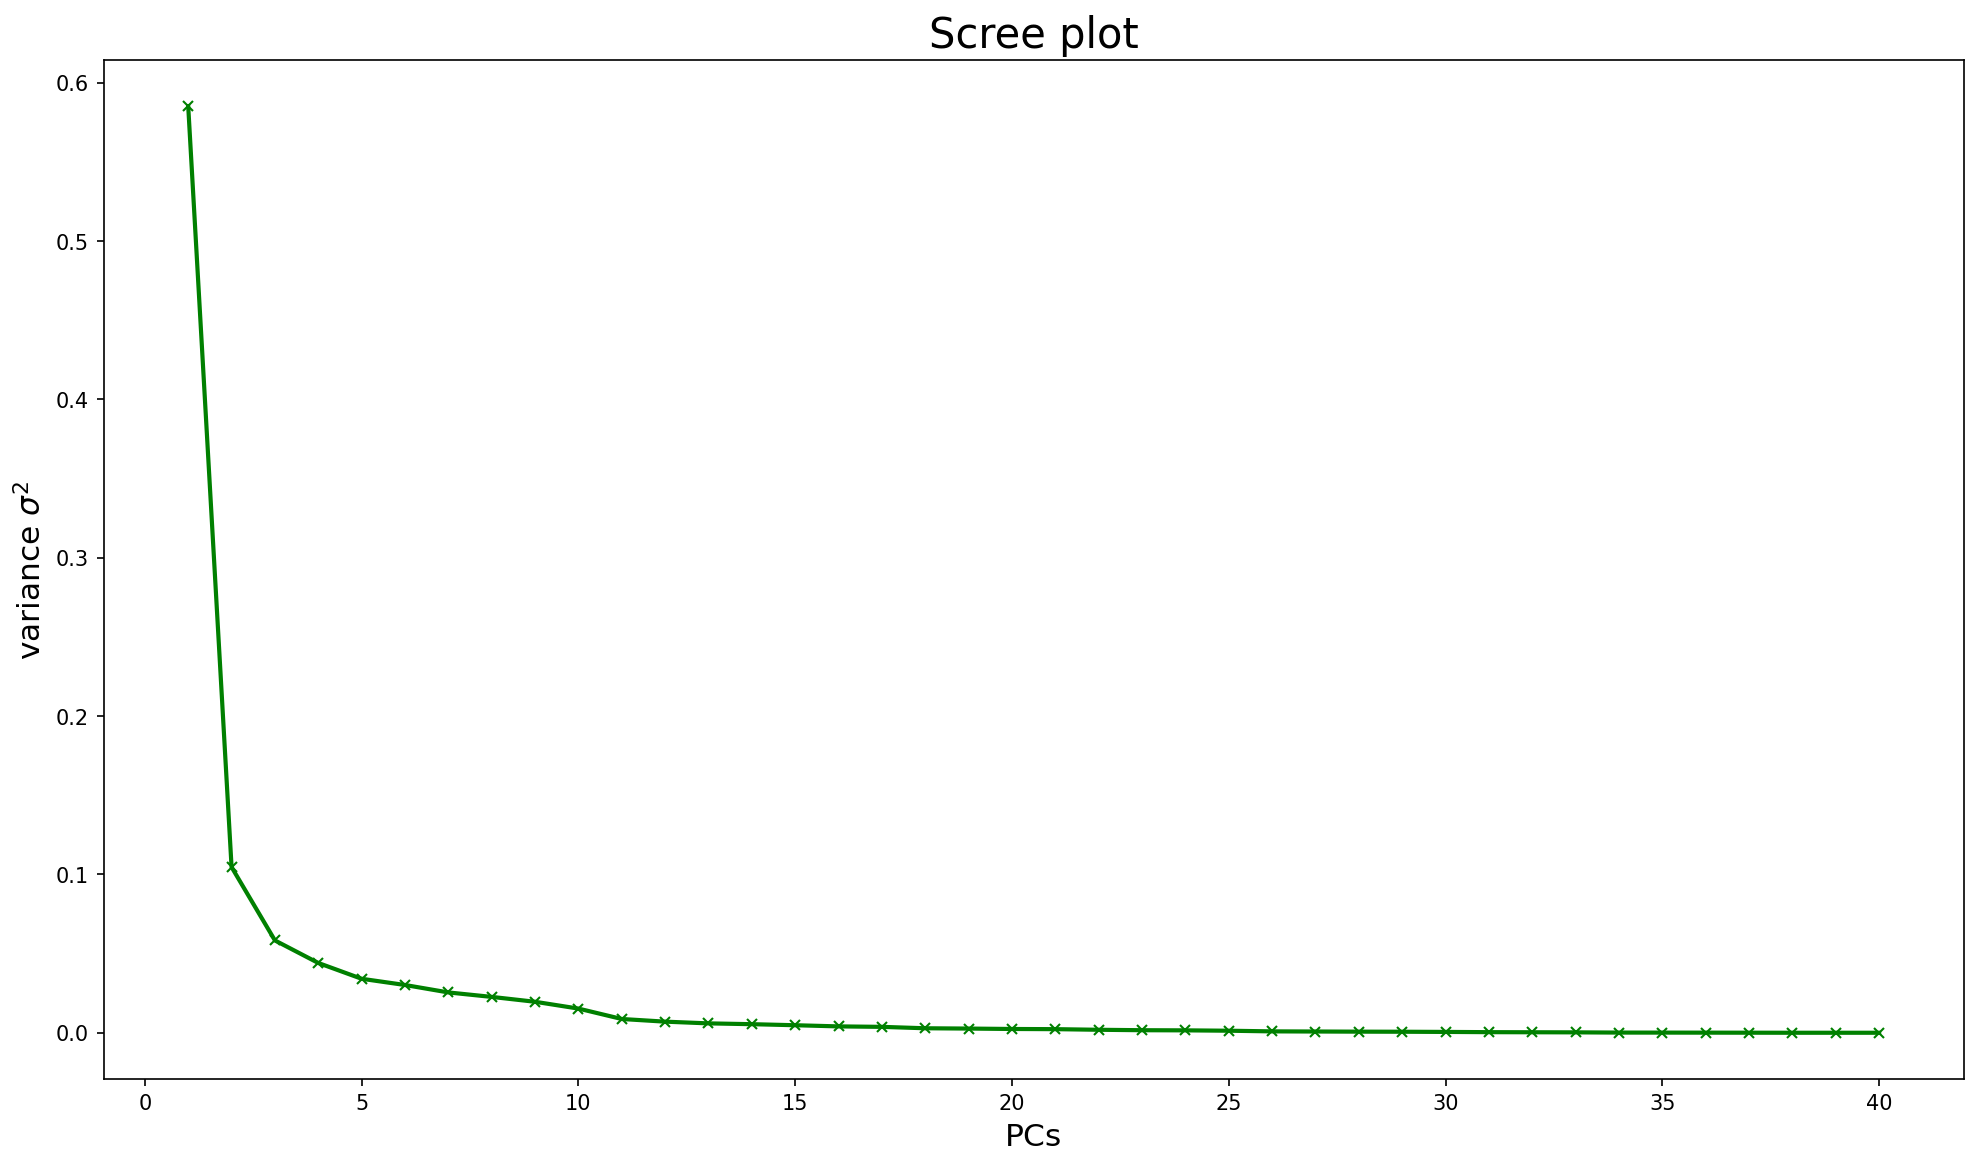

In [24]:
X = np.array(range(1,N+1))
variance = pca.explained_variance_ratio_;

fig, ax = plt.subplots(figsize=(16, 9), dpi = 150) 

ax.plot(X,variance, marker='x', ls='-', color='g', linewidth=2, markersize=5); 
ax.set_xlabel('PCs', fontsize=15) 
ax.set_ylabel('variance $\sigma^2$', fontsize=15)
plt.title('Scree plot', fontsize=20)
plt.show()

In this problem, you will train a `LinearRegression` model to predict the `y` data with each of the principal components and see how the model performance changes for each of the principal components. Create a plot of **$\mathrm{r^2}$ vs. principal component vector number**.

- Declare a `LinearRegression(fit_intercept=True)` model and train it with the data projected onto the ***i***-th principal component where ***i*** ranges from 0 to 39. You do not need to perform a train/test split, since there is no risk of overfitting with only one fitted parameter and >10K data points.
- Obtain the $\mathrm{r^2}$ on the full dataset for each model and plot (`i`, `r2_i`).

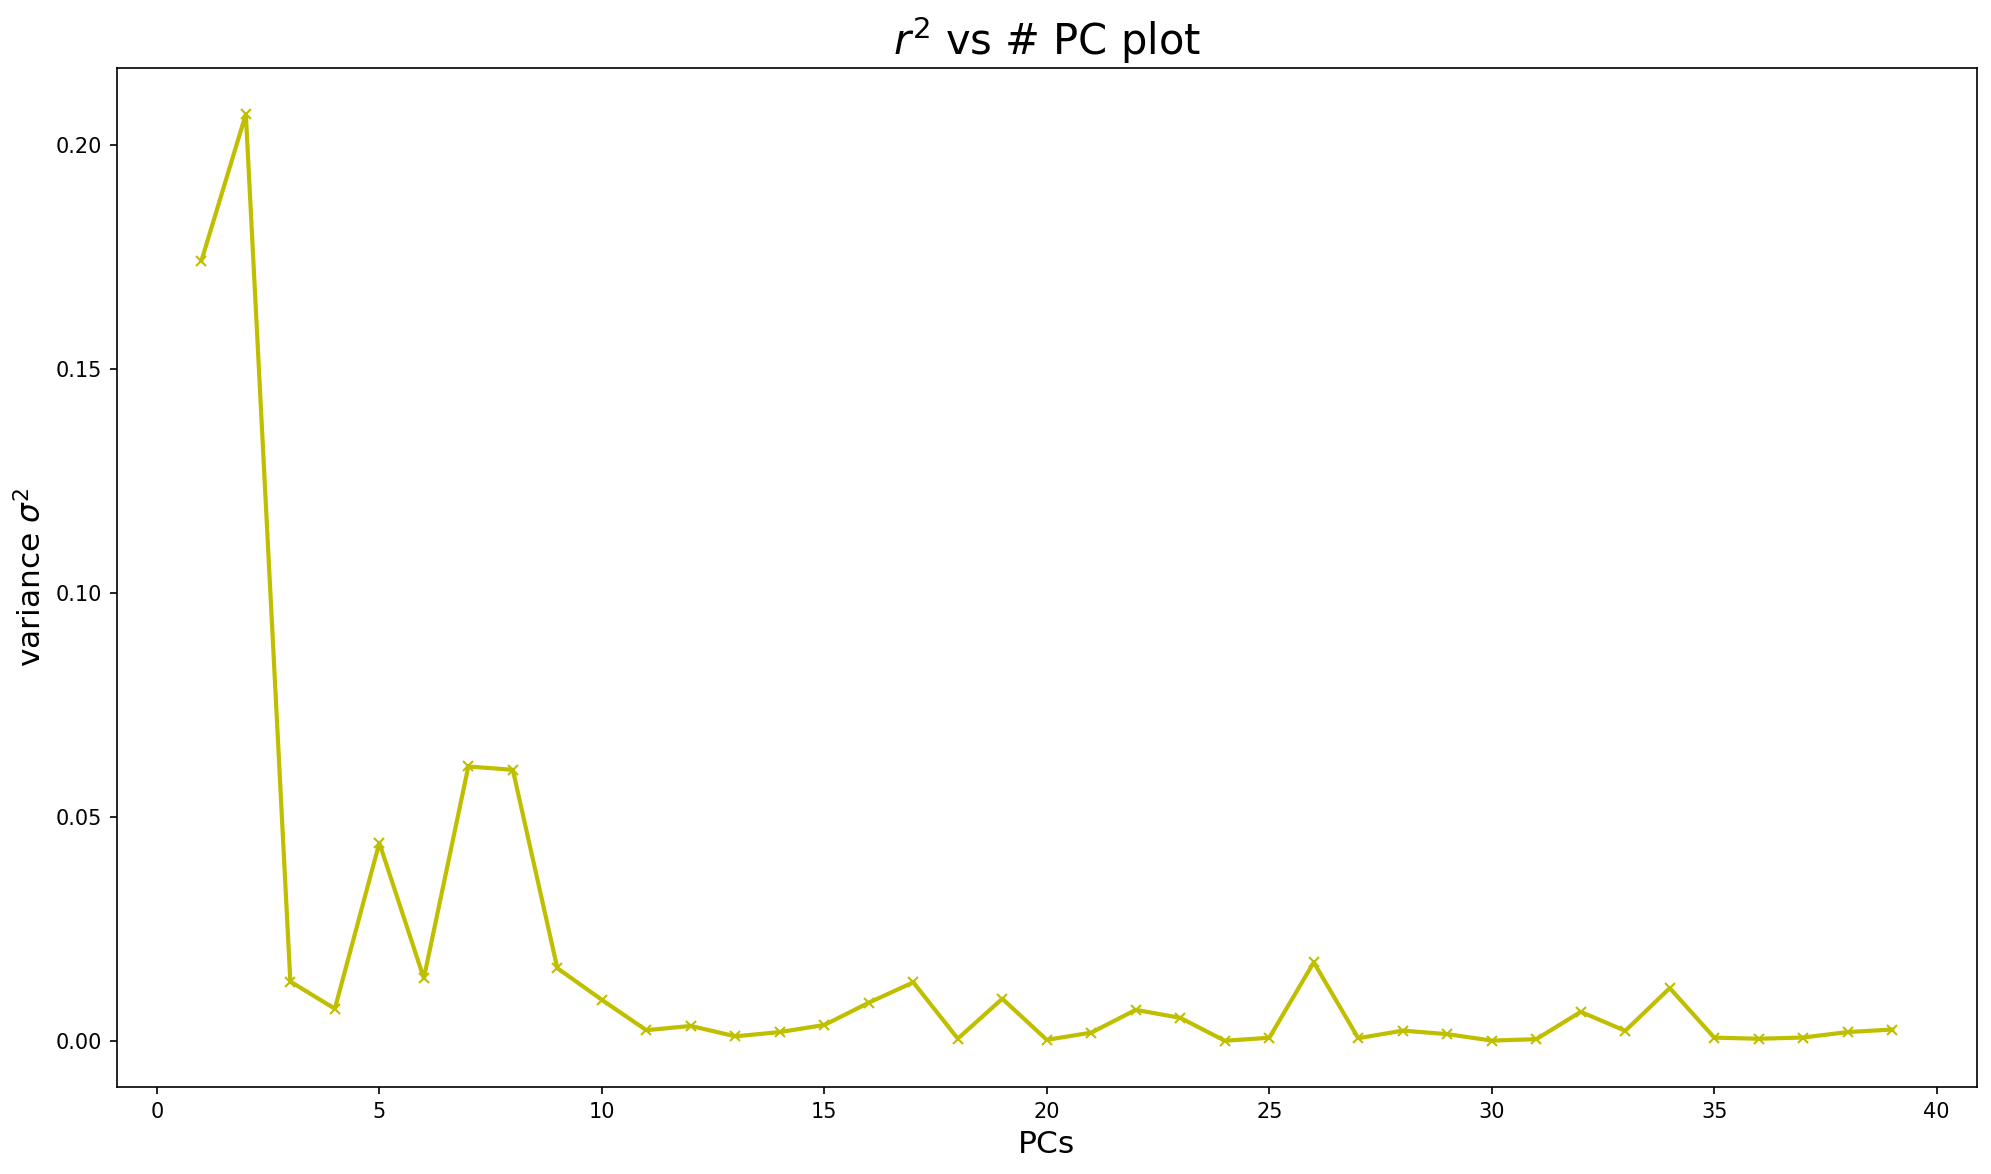

In [25]:
from sklearn.linear_model import LinearRegression

X= np.array(range(1,N))
r2 =[]
for i in range(0,39):
    lr = LinearRegression(fit_intercept=True).fit(PC_projection[:,i].reshape(-1,1),y )  ### reshaping toa 2D array to suit format
    r2.append(lr.score(PC_projection[:,i].reshape(-1,1),y))
    
fig, ax = plt.subplots(figsize=(16, 9), dpi = 150) 

ax.plot(X,r2, marker='x', ls='-', color='y', linewidth=2, markersize=5); 
ax.set_xlabel('PCs', fontsize=15) 
ax.set_ylabel('variance $\sigma^2$', fontsize=15)
plt.title('$r^2$ vs # PC plot', fontsize=20)
plt.show()

Compare the scree plot (variance explained by each component) to the r$^2$ plot (correlation between each component and the target data). Explain why the plots do not look the same. 

It can clearly be seen from the above plots that the $r^2$ values and the variance values are not equal and the trends are different. $r^2$ values explains the correlation between input and output, but when it comes to PCA, it is just the variance calculated for the input data, which need not necessarily correlate with the output!

Create the best model you can using only three fitted parameters of a linear model (this could be three slopes, or two slopes and an intercept). You can use any strategy you like, including feature scaling, and any model with an r$^2$ score of at least 0.3 will be considered correct.

In [26]:
# case with 2 slopes and 1 intercept
N= 2 #n_components
pca = PCA(n_components=N) 
projvecs = pca.fit_transform(X_scaled)

model1 = LinearRegression(fit_intercept = True)
model1.fit(projvecs, y)
r2 = round(model1.score(projvecs, y),4)
print("R^2 (2 slope, 1 intercept) = {}".format(r2))

# case with 3 slopes and no intercept
N= 3
pca = PCA(n_components=N) 
projvecs = pca.fit_transform(X_scaled)

model2 = LinearRegression(fit_intercept = False)
model2.fit(projvecs, y) 
r2 = round(model2.score(projvecs, y),4)
print("R^2 (3 slope, 0 intercept) = {}".format(r2))

R^2 (2 slope, 1 intercept) = 0.3809
R^2 (3 slope, 0 intercept) = -5.9523


Briefly describe the strategy you used to create the model.

Its a straightforward model wherein the PCA was used to extract the info from the 41-dimensional model by projecting it to $n$ (n=2, 3) dimensional space. The inbuilt PCA module was used and for the case where 3 slopes were used, ***fit_intercept*** value was kept as 'False' while defining the linear regression instance and the ***n_components*** value was defined as 3 while they were defined as  'True' and 2 when 2 slopes, 1 intercept were to be fitted.

The obtained values of the $R^2$ are mentioned above, and show that the 2-slope, 1-intercept model decribes the system with a $R^2$ >0.3